In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score


from subprocess import check_output
print(check_output(["ls", "/home/administrator/PycharmProjects/Uni/weekly_reports/data/titanic"]).decode("utf8"))

train_data = pd.read_csv('/home/administrator/PycharmProjects/Uni/weekly_reports/data/titanic/train.csv', dtype={'Age': np.float16})

train_data.head()

gender_submission.csv
test.csv
train.csv



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------


In [3]:
train_data=train_data.drop(['Cabin','PassengerId',"Ticket","Fare"], axis=1)

In [4]:
data = [train_data]
for dataset in data:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)
    Embarked = np.zeros(len(dataset))
    Embarked[dataset['Embarked']== 'C'] = 1
    Embarked[dataset['Embarked']== 'Q'] = 2
    Embarked[dataset['Embarked']== 'S'] = 3
    dataset['Embarked'] = Embarked

In [5]:
train_data['Age'].fillna(train_data['Age'].median(), inplace = True)

In [6]:
print('Train columns with null values:\n', train_data.isnull().sum())
print("-" * 10)

Train columns with null values:
 Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
dtype: int64
----------


In [7]:
data = [train_data]
for dataset in data:
    dataset['Age'] = dataset['Age']
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

train_data['Age'].value_counts()


4.0    303
6.0    150
3.0    106
5.0    101
2.0     92
1.0     71
0.0     68
Name: Age, dtype: int64

In [8]:
data = [train_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)

In [9]:
data = [train_data]
for dataset in data:
    sex = np.zeros(len(dataset))
    sex[dataset['Sex']== 'male'] = 1
    sex[dataset['Sex']== 'female'] = 0
    dataset['Sex'] = sex

In [10]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Title
0,0,3,1.0,2.0,1,0,3.0,1
1,1,1,0.0,5.0,1,0,1.0,3
2,1,3,0.0,3.0,0,0,3.0,2
3,1,1,0.0,5.0,1,0,3.0,3
4,0,3,1.0,5.0,0,0,3.0,1


In [11]:
X = train_data.drop("Survived", axis=1)
y= train_data["Survived"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y,test_size = 0.20)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

In [13]:
logreg = LogisticRegression(C=1e3, solver='liblinear', multi_class='auto')
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

# print(X_test)

# print(Y_train)
# print(Y_pred)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
logreg_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 2)

print("LOGREG score =" ,acc_log)
print("AUC SCORE = " ,logreg_auc_score)

LOGREG score = 80.48
AUC SCORE =  80.26


In [14]:
kf = StratifiedKFold(n_splits=10)

In [15]:
logreg = LogisticRegression(C=1e3, solver='liblinear', multi_class='auto')
logreg_scores = []
logreg_auc_scores = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test, Y_train, Y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logreg.fit(X_train, Y_train)
    logreg_scores.append(logreg.score(X_test, Y_test))
    logreg_auc_scores.append(roc_auc_score(Y_test, logreg.predict(X_test)))
print(
    'Logistic Regression Score = {}, AUC Score = {}'.format(
        round(sum(logreg_scores)/len(logreg_scores) *100 ,3),
        round(sum(logreg_auc_scores)/len(logreg_auc_scores)*100 , 3)
    )
)

Logistic Regression Score = 80.812, AUC Score = 79.187


In [16]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 3)
print("KNN SCORE" ,acc_knn)
knn_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,knn_auc_score)

KNN SCORE 85.803
AUC SCORE =  77.887


In [27]:
# KNN
knn_k_scores = []
knn_scores = []
knn_k_auc_scores = []
knn_auc_scores = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    for i in range(1, 20):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        knn_k_scores.append(knn.score(X_test, y_test))
        knn_auc_scores.append(roc_auc_score(y_test, knn.predict(X_test)))
    knn_scores.append(max(knn_k_scores))
    knn_auc_scores.append(max(knn_auc_scores))
    knn_k_scores = []
    knn_k_auc_scores = []

print(
    'KNN Score = {},AUC Score = {}'.format(
        round(sum(knn_scores)/len(knn_scores)*100, 3),
        round(sum(knn_auc_scores)/len(knn_auc_scores)*100, 3)
    )
)


KNN Score = 83.621,AUC Score = 78.023


In [18]:
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 3)
print("NAIVE BAYES SCORE" , acc_gaussian)
gauss_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,gauss_auc_score)

NAIVE BAYES SCORE 79.701
AUC SCORE =  83.388


In [19]:
# Naive Bayes
nb_scores = []
nb_auc_scores = []
nb = GaussianNB()
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    nb.fit(X_train, y_train)
    nb_scores.append(nb.score(X_test, y_test))
    nb_auc_scores.append(roc_auc_score(y_test, nb.predict(X_test)))
print(
    "Naive Bayes Score = {}, AUC Score = {}".format(
        round(sum(nb_scores)/len(nb_scores)*100, 3),
        round(sum(nb_auc_scores)/len(nb_auc_scores)*100, 3)
    )
)

Naive Bayes Score = 79.918, AUC Score = 79.566


In [20]:
linear_svc = SVC(C=100, kernel="linear", random_state=1)
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 3)
print("SVM score" ,acc_linear_svc)
linear_auc_score = round(roc_auc_score(Y_test, Y_pred) * 100, 3)
print("AUC SCORE = " ,linear_auc_score)

SVM score 78.705
AUC SCORE =  73.638


In [21]:
# SVM
svm_scores = []
svm_auc_scores = []
SVM = SVC(C=100, kernel="linear", random_state=1)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    SVM.fit(X_train, y_train)
    svm_scores.append(SVM.score(X_test, y_test))
    svm_auc_scores.append(roc_auc_score(y_test, SVM.predict(X_test)))
    

print(
    "SVM Score = {}, AUC Score = {}".format(
        round(sum(svm_scores)/len(svm_scores)*100, 3),
        round(sum(svm_auc_scores)/len(svm_auc_scores)*100, 3)
    )
)

SVM Score = 78.22, AUC Score = 76.477


In [22]:
names = ['SVM' , 'KNN', 'LOGREG', 'NAIVE BAYES']
auc_scores_before_kfold = [linear_auc_score,
                           knn_auc_score,
                           logreg_auc_score, 
                           gauss_auc_score]
auc_scores_after_kfold = [round(sum(svm_auc_scores)/len(svm_auc_scores)*100, 3),
                           round(sum(knn_auc_scores)/len(knn_auc_scores)*100, 3),
                           round(sum(logreg_auc_scores)/len(logreg_auc_scores)*100 , 3), 
                           round(sum(nb_auc_scores)/len(nb_auc_scores)*100, 3)]

accuracy_before_kfold = [acc_linear_svc,
                         acc_knn,
                         acc_log,
                         acc_gaussian]

accuracy_after_kfold = [round(sum(svm_scores)/len(svm_scores)*100, 3),
                         round(sum(knn_scores)/len(knn_scores)*100, 3),
                         round(sum(logreg_scores)/len(logreg_scores) *100 ,3),
                         round(sum(nb_scores)/len(nb_scores)*100, 3)
                        ]

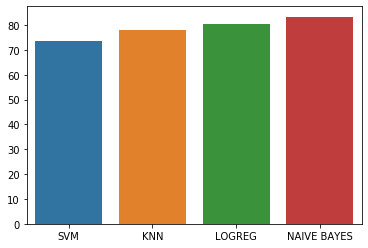

In [23]:
ax = sns.barplot(x= names, y= auc_scores_before_kfold)

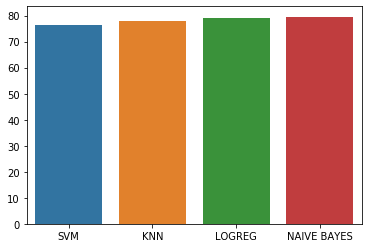

In [24]:
ax = sns.barplot(x= names, y= auc_scores_after_kfold)

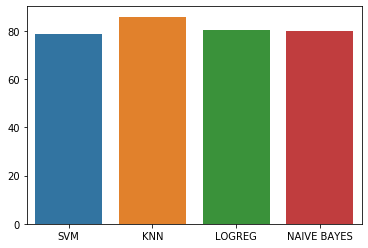

In [25]:
ax = sns.barplot(x= names, y= accuracy_before_kfold)

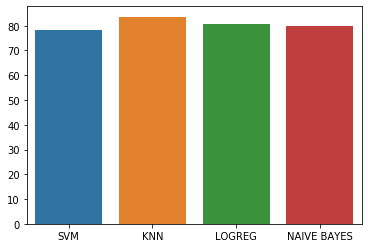

In [26]:
ax = sns.barplot(x= names, y= accuracy_after_kfold)